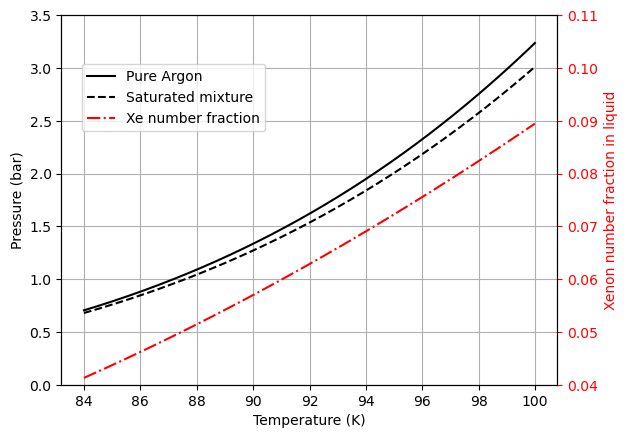

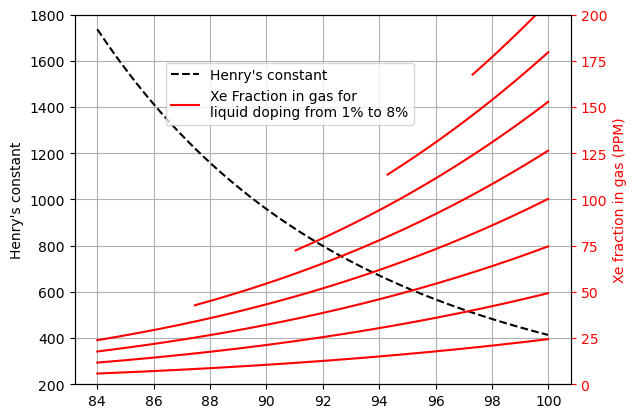

In [3]:
# Original author: Ethan Bernard (bernard5@llnl.gov)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

dT = 0.01
T = np.arange(84, 100, dT)  # T in K

Temp = np.arange(84, 100, 0.01)


def Ar_vap_P(T):
    # Pure Ar vapor pressure

    T_Ar_crit = 150.687  # K
    P_Ar_crit = 4.863  # MPa

    a_1 = -5.9409785
    a_2 = 1.3553888
    a_3 = -0.46497607
    a_4 = -1.5399043

    q = 1 - (T / T_Ar_crit)

    pure_Ar_ln_ratio = (T_Ar_crit / T) * (
        a_1 * q + a_2 * q ** (3 / 2) + a_3 * q**2 + a_4 * q ** (9 / 2)
    )

    return 10 * P_Ar_crit * np.exp(pure_Ar_ln_ratio)


# saturated liquid fraction from Yunker Halsey paper


def eta_sat_liq(T):
    # eta is the xenon number fraction in the liquid

    return np.exp(1.6463 - 406 / T)


def Tsat_from_eta(eta):
    return 406 / (1.6463 - np.log(eta))


def sat_mix_vap_P(T):
    # Argon Vap Pressure depression from Yunker Halsey

    alpha = 269.2  # K
    return Ar_vap_P(T) * np.exp(
        np.log(1 - eta_sat_liq(T)) + (alpha / T) * np.power(eta_sat_liq(T), 2)
    )


def unsat_mix_vap_P(T, eta):
    # Sat limit and Vap Pressure depression modified Raoult's from Yunker Halsey

    alpha = 269.2  # K
    return Ar_vap_P(T) * np.exp(np.log(1 - eta) + (alpha / T) * np.power(eta, 2))


def logP_guess_LF(T, P):
    # Xe vap pressure by Lobo Ferreira paper.  Use by calling iteratively over P.  This sort of matches their graph at ~ 90 K but is way too high at 162 K.
    # I suspect a misprinted number in their paper but maybe I have a bug.  This is not used elsewhere

    Xe_triple_T = 161.404
    Xe_triple_P = 81675  # Pa

    A = 18.5232
    B = 1916.032
    C = 1.6106
    D_2 = -3.6187 * 10 ** (-2)
    D_3 = 1.2368 * 10 ** (-4)
    D_4 = 2.2324 * 10 ** (-7)

    xenon_D_fxn = D_2 * T + D_3 * T**2 + D_4 * T**3

    E_1 = 14.712 * 10 ** (-10)
    E_2 = 0.9844 * 10 ** (-11)
    E_3 = 7.2877 * 10 ** (-6)
    E_4 = -4.2501 * 10 ** (-4)
    E_5 = 1.295

    xenon_E_fxn = E_1 + E_2 * T + E_3 / T + E_4 / T**2 + E_5 / T**3

    return A - (B / T) + (C * np.log(T)) + xenon_D_fxn + xenon_E_fxn * P


def solid_Xe_vap_P_LP(T):  # returning in bar
    # Xe vap pressure by Leming and Pollack 1970
    # Using their fit for the 76 to 104 K range, table 3 eq 4.  This is what I use for other functions and the graphs

    A = -1960.37
    B = 18.9607  #
    L = 3895  # cal / mol

    return 10**-5 * 133.322368 * np.exp(B + (A / T))  # consts give Torr so convert


# xenon vapor pressure calc


def Xe_unsat_vap_P(T, eta):  # returning in bar
    return solid_Xe_vap_P_LP(T) * (eta / eta_sat_liq(T))


# xenon vapor pressure calc


def fraction_in_gas(T, eta):
    return Xe_unsat_vap_P(T, eta) / unsat_mix_vap_P(T, eta)


def liq_frac_over_gas_frac(
    T, eta
):  # This is Henry's const if called with vanishingly small eta.
    return eta / fraction_in_gas(T, eta)


# import libraries

rc("mathtext", default="regular")

# Creating dataset
x = np.arange(10)
dataset_1 = np.random.random(10) * 30
dataset_2 = np.random.random(10) * 60
dataset_3 = np.random.random(10) * 100

# Creating figure
fig = plt.figure()

# Plotting dataset_2
ax = fig.add_subplot(111)
ax.plot(T, Ar_vap_P(T), "k-", label="Pure Argon")
ax.plot(T, sat_mix_vap_P(T), "k--", label="Saturated mixture")

# Creating Twin axes for dataset_1
ax2 = ax.twinx()
ax2.plot(T, eta_sat_liq(T), "r-.", label="Xe number fraction")

# Adding title
# plt.title('Use different y-axes on the left and right of a Matplotlib plot',
# fontweight="bold")

# adding grid
ax.grid()

# Adding labels
ax.set_xlabel("Temperature (K)")
ax2.set_ylabel(r"Xenon number fraction in liquid")
ax2.yaxis.label.set_color("red")
ax2.tick_params(colors="red", which="both")
ax.set_ylabel(r"Pressure (bar)")


# Setting Y limits
ax2.set_ylim(0.04, 0.11)
ax.set_ylim(0.0, 3.5)

# Adding legend
fig.legend(loc=(0.13, 0.70))
# ax.legend(loc=0)
# ax2.legend(loc=0)

# Show plot
plt.savefig("assets/Sat.svg", bbox_inches="tight")
plt.show()
#########


# Evolved example fourth plot

# import libraries

rc("mathtext", default="regular")

# Creating figure
fig = plt.figure()

# Plotting dataset_2
ax = fig.add_subplot(111)
ax.plot(T, liq_frac_over_gas_frac(T, 0.000001), "k--", label="Henry's constant")

ax2 = ax.twinx()

etalist = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08)
for i in etalist:
    T_min = max(round(Tsat_from_eta(i), 100), 84)
    T_lim = np.arange(T_min, 100, dT)
    if i == 0.01:
        ax2.plot(
            T_lim,
            10**6 * fraction_in_gas(T_lim, i),
            "r-",
            label="Xe Fraction in gas for \nliquid doping from 1% to 8%",
        )
    else:
        ax2.plot(T_lim, 10**6 * fraction_in_gas(T_lim, i), "r-")

ax2.yaxis.label.set_color("red")
ax2.tick_params(colors="red", which="both")


# Creating Twin axes for dataset_1


# Adding title
# plt.title('Use different y-axes on the left and right of a Matplotlib plot',
# fontweight="bold")

# adding grid
ax.grid()

# Adding labels
ax2.set_xlabel("Temperature (K)")
ax.set_ylabel(r"Henry's constant")
ax2.set_ylabel(r"Xe fraction in gas (PPM)")

# Setting Y limits
ax.set_ylim(200, 1800)
ax2.set_ylim(0.0, 200)

# Adding legend
fig.legend(loc=(0.26, 0.70))
# ax.legend(loc=0)
# ax2.legend(loc=0)

# Show plot
plt.savefig("assets/Henry.svg", bbox_inches="tight")
plt.show()